In [ ]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers

import jax.numpy as jnp
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
pip install polygon-api-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
import polygon_interface
import yahoo_interface

# **Data Processing**


In [ ]:
# function for creating sequences to feed into model
def create_training_sequences(data, window_size):
    """
      Returns a list of windows in data of length window_size
          and a list containing corresponding to the data value immediately proceeding a window

      :param data: a numpy array of shape (n, 1), e.g. closing_prices
      :param window_size: length of window
    """

    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i: i + window_size, 0])    # closing prices in last (seq_length)-days
        y.append(data[i + window_size, 0])       # closing price in day after the x-sequence
    return np.array(X), np.array(y)

In [ ]:
tickers = ['AAPL', 'COST', 'CVX', 'WM', 'LLY']

chunk_size = 365
window_size = 60
X_train = np.empty((0,60), dtype = 'float64')
X_val = np.empty((0,60), dtype = 'float64')
y_train = np.empty((0), dtype = 'float64')
y_val = np.empty((0), dtype = 'float64')

for ticker in tickers:
  df = yahoo_interface.get_all_features(ticker, '2000-01-01', '2025-03-10', smoothing = True, alpha = 0.5)
  for i in range(len(df)//chunk_size):
    # get chunk of dataframe
    df_chunk = df[i*chunk_size: min((i+1)*chunk_size, len(df))]

    # Put closing prices into numpy array
    closing_prices = df_chunk['Close'].values.reshape(-1, 1)

    # Normalize the data between [0,1]
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_data = scaler.fit_transform(closing_prices)

    # Define training and validation sizes
    train_size = int(len(df_chunk) * 0.7)
    val_size = len(df_chunk) - train_size

    # Split into training and validation sets
    train, val = scaled_data[: train_size, :], scaled_data[train_size:, :]

    # Using the data sets, create sequences to feed into model
    X, y = create_training_sequences(train, window_size)
    X_train = np.concatenate((X_train, X))
    y_train = np.concatenate((y_train, y))

    X, y = create_training_sequences(val, window_size)
    X_val = np.concatenate((X_val, X))
    y_val = np.concatenate((y_val, y))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

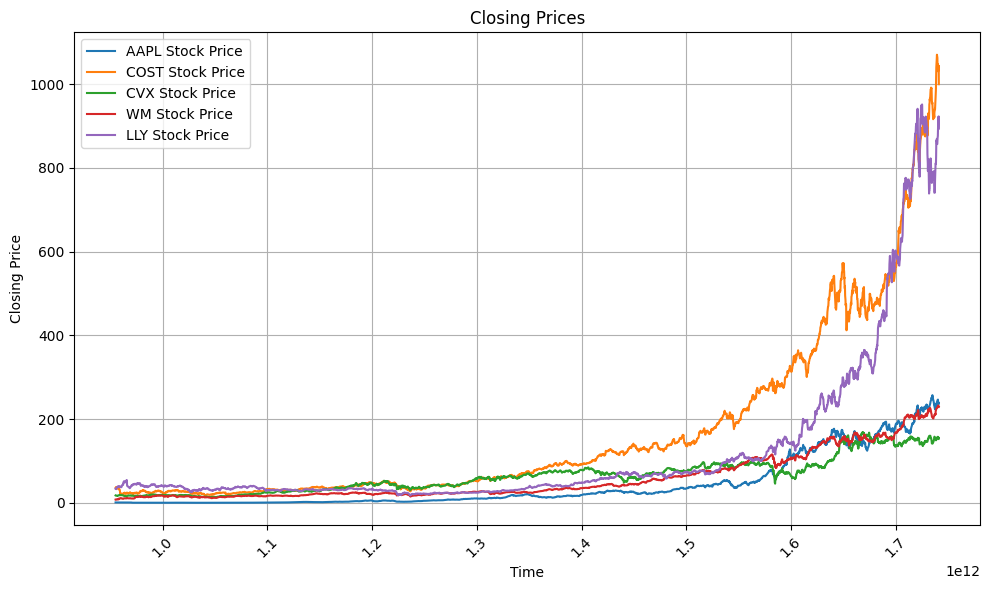

In [ ]:
# Plotting the closing prices
plt.figure(figsize=(10, 6))
for ticker in tickers:
  df = yahoo_interface.get_all_features(ticker, '2000-01-01', '2025-03-10', smoothing = True, alpha = 0.5)
  plt.plot(df['Timestamp'], df['Close'], label = f'{ticker} Stock Price')
  plt.xlabel('Time')
  plt.ylabel('Closing Price')
  plt.xticks(rotation=45)
  plt.grid(True)
plt.legend()
plt.title('Closing Prices')
plt.tight_layout()
plt.show()

# **Model Construction and Training**

In [ ]:
model = keras.Sequential([
    layers.LSTM(32, return_sequences = True, input_shape = (60, 1)),
    layers.Dropout(0.2),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 60, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,297 (122.25 KB)

 Trainable params: 31,297 (122.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = 50, validation_data=(X_val, y_val))


Epoch 1/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0188 - val_loss: 0.0031
Epoch 2/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0060 - val_loss: 0.0017
Epoch 3/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0038 - val_loss: 0.0012
Epoch 4/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 5/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0024 - val_loss: 8.2098e-04
Epoch 6/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0022 - val_loss: 7.5746e-04
Epoch 7/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0020 - val_loss: 8.0416e-04
Epoch 8/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0019 - val_loss: 5.2448e-04
Epoch 9/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0018 - val_loss: 8.3605e-04
Epoch 10/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 11/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0019 - val_loss: 5.9644e-04
Epoch 12/50
51

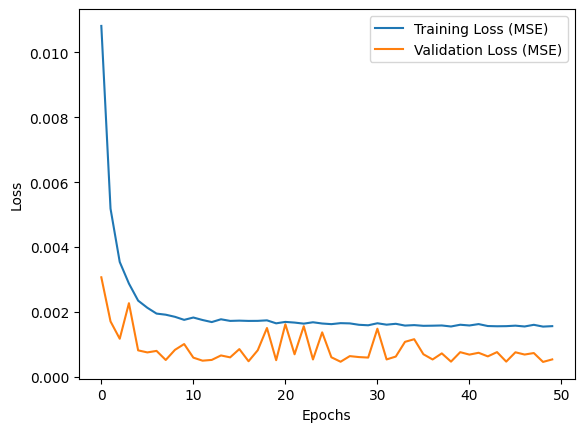

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.save_weights('LSTM_weights.weights.h5')
# model.load_weights('LSTM_weights.weights.h5')

# Performance on Unsmoothed Data

In [ ]:
# modified version of create_training_sequences. Only outputs X array, not y array
def create_sequences(data, window_size):
    """
      Returns a list of windows in data of length window_size
          and a list containing corresponding to the data value immediately proceeding a window

      :param data: a numpy array of shape (n, 1), e.g. closing_prices
      :param window_size: length of window
    """

    X = []
    for i in range(len(data) - window_size + 1):
        X.append(data[i: i + window_size, 0])    # closing prices in last (seq_length)-days
    return np.array(X)

In [ ]:
# reading data
df = yahoo_interface.get_all_features('AAPL', '2023-01-01', '2025-01-01', smoothing = False)
closing_prices = df['Close'].values.reshape(-1, 1)
scaled_data = scaler.fit_transform(closing_prices)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# formatting data to be fed into model
window_size = 60
X_full = create_sequences(scaled_data, window_size)

# getting predictions
full_predict = model.predict(X_full)
full_predict = scaler.inverse_transform(full_predict)

mse = mean_squared_error(closing_prices[59:], full_predict)
print(f"Mean Squared Error: {mse}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Mean Squared Error: 1.358116348918956


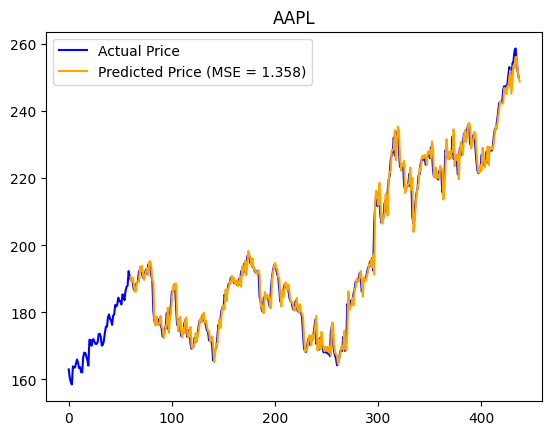

In [ ]:
# Formatting data into arrays to be plotted
known_plot = np.empty((closing_prices.shape[0] + 1, 1))
known_plot[:, :] = np.nan
known_plot[:closing_prices.shape[0], :] = closing_prices

prediction_plot = np.empty((closing_prices.shape[0] + 1, 1))
prediction_plot[:, :] = np.nan
prediction_plot[window_size: closing_prices.shape[0] + 1, :] = full_predict

# Plot actaul vs predictions
plt.plot(known_plot, color = 'blue', label = 'Actual Price')
plt.plot(prediction_plot, color = 'orange', label = f'Predicted Price (MSE = {mse:.3f})')
plt.title('AAPL')
plt.legend()
plt.show()

#**Performance on Different Stocks**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


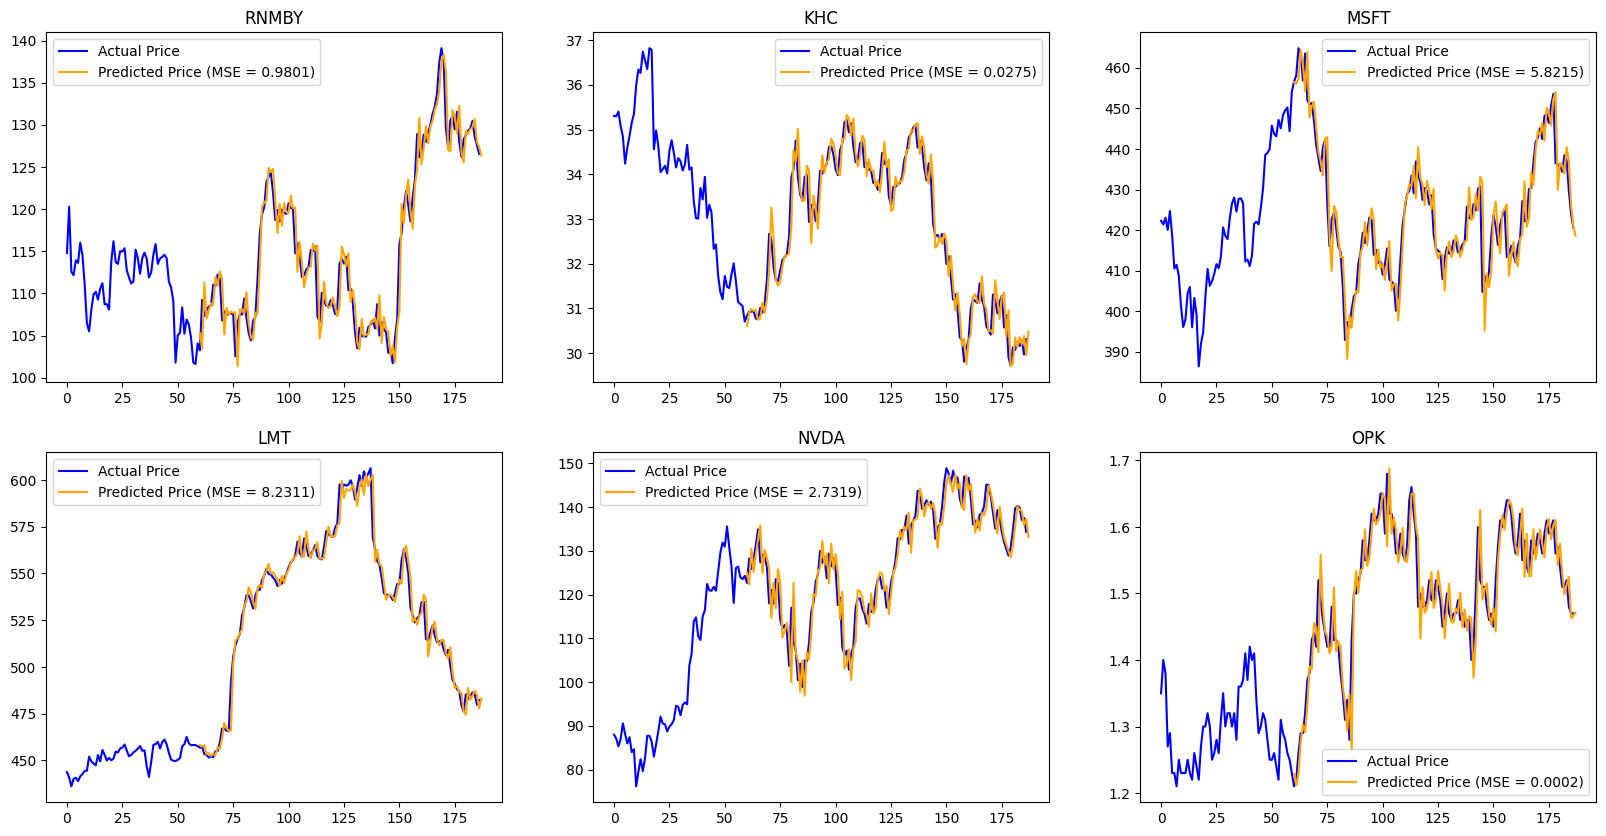

In [ ]:
tickers = ['RNMBY', 'KHC', 'MSFT', 'LMT', 'NVDA', 'OPK']

plt.figure(figsize = (20,10))
for i in range(6):
  # reading data
  df = yahoo_interface.get_all_features(f'{tickers[i]}', '2024-01-01', '2025-01-01', smoothing = False)
  closing_prices = df['Close'].values.reshape(-1, 1)
  scaled_data = scaler.fit_transform(closing_prices)

  # formatting data to be fed into model
  window_size = 60
  X_full = create_sequences(scaled_data, window_size)

  # getting predictions
  full_predict = model.predict(X_full)
  full_predict = scaler.inverse_transform(full_predict)
  mse = mean_squared_error(closing_prices[59:], full_predict)

  # Plotting real vs predicted prices
  known_plot = np.empty((closing_prices.shape[0] + 1, 1))
  known_plot[:, :] = np.nan
  known_plot[:closing_prices.shape[0], :] = closing_prices

  prediction_plot = np.empty((closing_prices.shape[0] + 1, 1))
  prediction_plot[:, :] = np.nan
  prediction_plot[window_size: closing_prices.shape[0] + 1, :] = full_predict

  # set up subplots
  plt.subplot(2,3,i+1)
  plt.title(f'{tickers[i]}')
  plt.plot(known_plot, color = 'blue', label = 'Actual Price')
  plt.plot(prediction_plot, color = 'orange', label = f'Predicted Price (MSE = {mse:.4f})')
  plt.legend()

plt.show()

# **Applying the Model for Forecasting**

In [ ]:
import math

# Used to keep values in [0,1]
def proj(x, a, b):
  """
  Projects a number x onto the interval [a,b]
  Values in [a,b] are projected onto themselves
  Values less than a are projected onto a
  Values greater than b are projected onto b
    :param x: number to be projected onto [a,b]
    :param a: left endpoint of interval [a,b]
    :param b: right endpoint of interval [a,b]
  """
  return max(min(x, b), a)

# Used to add noise to stock predictions
def noise():
    """
    Takes one sample of a normal distribution with mean 0, stdev = 0.33, projected onto [-1,1]
    """
    value = np.random.normal(0, 0.33, 1)
    return proj(value, -1,1 )

In [ ]:
# Used to generate predictions using the LSTM model

scaler = MinMaxScaler(feature_range = (0, 1))

def forecast(stock_data, days_forward = 60):
  """
  Generates predictions for a stock given 60 days of historical data
  Returns an appended version of scaled_data with predictions appearing at the end of the array
    :param stock_data: a dataframe containing a column titled 'Close', with at least 60 rows
    :param days_forward: the number of days in the future we want to forecast
  """

  scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))

  # initialize array to store future values
  forecast_arr = scaled_data

  # get predictions
  for i in range(days_forward):
    # get last 60 days in array
    seq = create_sequences(forecast_arr[-60:], window_size)

    # predict next day using model
    one_predict = model.predict(seq, verbose = 0)

    # add noise to prediction
    updated_value = np.array(one_predict[0][0].item()*(1 + 0.1 * noise()))
    one_predict[0][0] = updated_value.item()

    # add prediction to array
    forecast_arr = np.concatenate((forecast_arr, one_predict))

  # reverse data scaling
  forecast_arr = scaler.inverse_transform(forecast_arr)

  return forecast_arr

In [ ]:
# Used to generate a multiple random forecasts
def forecast_ensemble(stock_data, days_forward = 60, size = 10):
  """
  Calls forecast() several times and returns a list of forecast arrays
    :param stock_data: a dataframe containing a column titled 'Close', with at least 60 rows
    :param days_forward: the number of days in the future we want to forecast
    :param size: size of output list, i.e. number of times forecast() is called
  """

  forecast_list = []
  for i in range(size):
    forecast_list.append(forecast(df_predictor, days_forward))

  return forecast_list

[*********************100%***********************]  1 of 1 completed


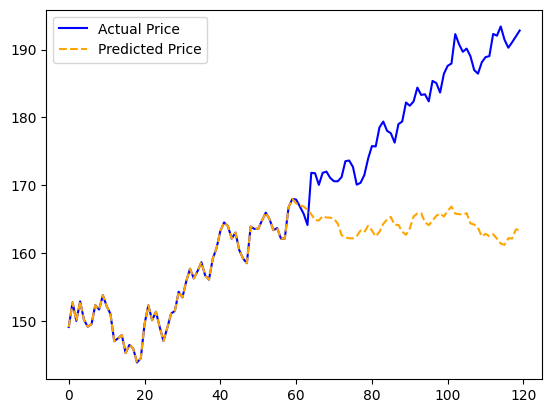

In [ ]:
days_forward = 60
size = 1

df_full = yahoo_interface.single_stock_table('AAPL', '2023-02-02', '2024-01-01')
df_predictor = df_full[:60]

# Getting predictions
forecast_list = forecast_ensemble(df_predictor, days_forward, size)

# Plotting real prices
known_plot = np.empty((60 + days_forward, 1))
known_plot[:, :] = np.nan
known_plot[:, :] = df_full['Close'][:60 + days_forward].values.reshape(-1,1)
plt.plot(known_plot, color = 'blue', label = 'Actual Price')

# Plotting predictions
prediction_plots = []
for j in range(size):
  prediction_plots.append(np.empty((60 + days_forward, 1)))
  prediction_plots[j][:, :] = np.nan
  prediction_plots[j][: window_size + days_forward, :] = forecast_list[j]
  if j == 0:
    plt.plot(prediction_plots[j],  linestyle = ':', color = 'orange', label = 'Predicted Price')
  else:
    plt.plot(prediction_plots[j],  linestyle = ':', color = 'orange')

plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


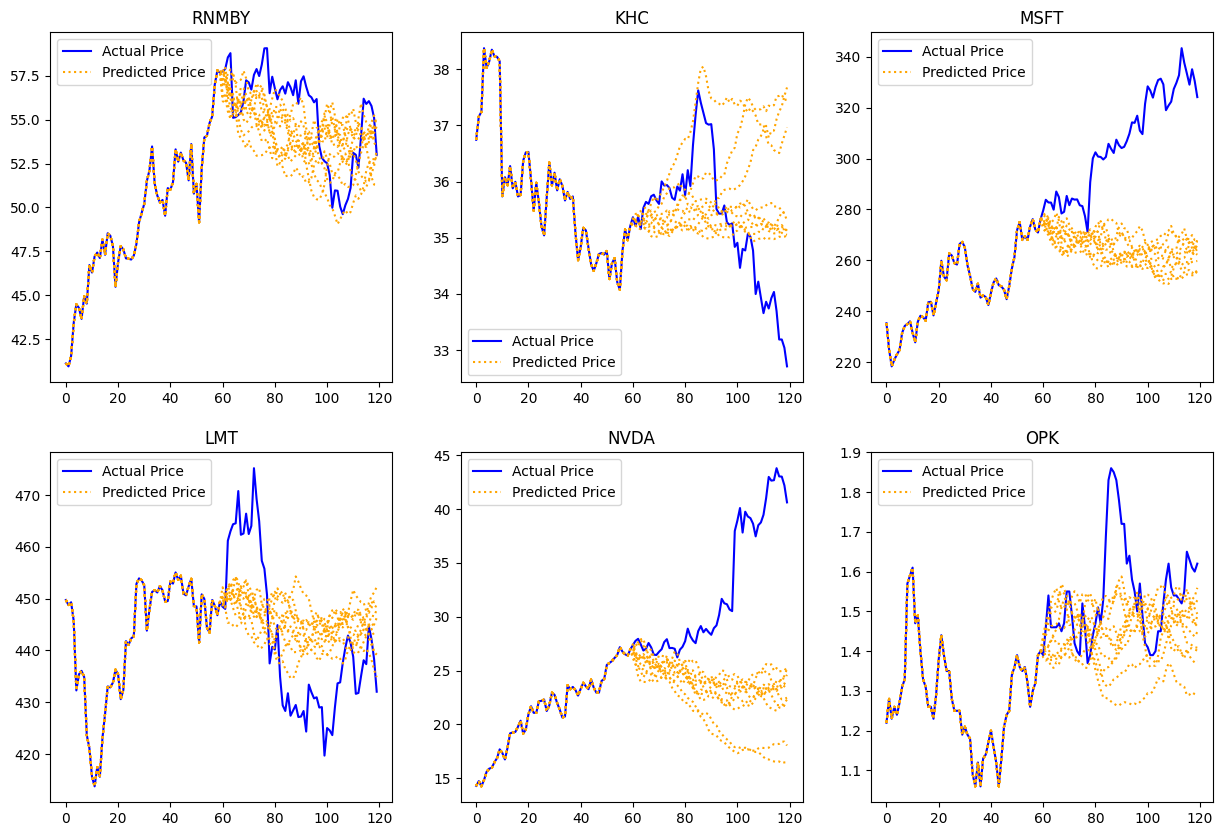

In [ ]:
tickers = ['RNMBY', 'KHC', 'MSFT', 'LMT', 'NVDA', 'OPK']
days_forward = 60
size = 10

plt.figure(figsize = (15,10))
for i in range(len(tickers)):
  # reading data
  df_full = yahoo_interface.single_stock_table(f'{tickers[i]}', '2023-01-01', '2024-01-01')
  df_predictor = df_full[:60]

  # Getting predictions
  forecast_list = forecast_ensemble(df_predictor, days_forward, size)

  # Set up subplot
  plt.subplot(2,3,i+1)

  # Plotting real prices
  known_plot = np.empty((60 + days_forward, 1))
  known_plot[:, :] = np.nan
  known_plot[:, :] = df_full['Close'][:60 + days_forward].values.reshape(-1,1)
  plt.plot(known_plot, color = 'blue', label = 'Actual Price')

  # Plotting predicted prices
  plt.title(f'{tickers[i]}')
  prediction_plots = []
  for j in range(size):
    prediction_plots.append(np.empty((60 + days_forward, 1)))
    prediction_plots[j][:, :] = np.nan
    prediction_plots[j][: window_size + days_forward, :] = forecast_list[j]
    if j == 0:
      plt.plot(prediction_plots[j], color = 'orange', linestyle = ':', label = 'Predicted Price')
    else:
      plt.plot(prediction_plots[j], color = 'orange', linestyle = ':')

  plt.legend()

plt.show()